In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from ipywidgets import interact
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.head()
# importing data set

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,id
0,303,CASH_IN,185164.71,C1499985475,3075480.01,3260644.72,C1771727877,881991.88,696827.18,0,540576
1,356,CASH_IN,79083.65,C108745493,5489716.32,5568799.97,C1167754301,153219.51,74135.86,0,120014
2,10,TRANSFER,2336832.78,C975415534,147958.78,0.00,C718985478,5069347.06,7307970.46,0,623141
3,238,TRANSFER,228517.91,C1968162743,0.00,0.00,C1544755390,18768561.09,18997079.00,0,547737
4,133,CASH_IN,180179.73,C467196066,21448.00,201627.73,C1386847873,7160295.13,6980115.40,0,569291


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509009 entries, 0 to 509008
Data columns (total 11 columns):
step              509009 non-null int64
type              509009 non-null object
amount            509009 non-null float64
nameOrig          509009 non-null object
oldbalanceOrg     509009 non-null float64
newbalanceOrig    509009 non-null float64
nameDest          509009 non-null object
oldbalanceDest    509009 non-null float64
newbalanceDest    509009 non-null float64
isFraud           509009 non-null int64
id                509009 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 42.7+ MB


In [4]:
df['Recipient'] = df['nameDest'].str[:1]
df.head()
# Splitting nameDest to retain letter

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,id,Recipient
0,303,CASH_IN,185164.71,C1499985475,3075480.01,3260644.72,C1771727877,881991.88,696827.18,0,540576,C
1,356,CASH_IN,79083.65,C108745493,5489716.32,5568799.97,C1167754301,153219.51,74135.86,0,120014,C
2,10,TRANSFER,2336832.78,C975415534,147958.78,0.00,C718985478,5069347.06,7307970.46,0,623141,C
3,238,TRANSFER,228517.91,C1968162743,0.00,0.00,C1544755390,18768561.09,18997079.00,0,547737,C
4,133,CASH_IN,180179.73,C467196066,21448.00,201627.73,C1386847873,7160295.13,6980115.40,0,569291,C


In [5]:
df1 = df.ix[:, [0, 1, 2, 4, 5, 7, 8, 9, 11]]
df1.head()
# dropping unwanted columns

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Recipient
0,303,CASH_IN,185164.71,3075480.01,3260644.72,881991.88,696827.18,0,C
1,356,CASH_IN,79083.65,5489716.32,5568799.97,153219.51,74135.86,0,C
2,10,TRANSFER,2336832.78,147958.78,0.00,5069347.06,7307970.46,0,C
3,238,TRANSFER,228517.91,0.00,0.00,18768561.09,18997079.00,0,C
4,133,CASH_IN,180179.73,21448.00,201627.73,7160295.13,6980115.40,0,C


In [6]:
df1 = pd.get_dummies(df1, prefix='was', prefix_sep='_')
df1.head()
# encoding categorical features

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER,was_C,was_M
0,303,185164.71,3075480.01,3260644.72,881991.88,696827.18,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,356,79083.65,5489716.32,5568799.97,153219.51,74135.86,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10,2336832.78,147958.78,0.00,5069347.06,7307970.46,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,238,228517.91,0.00,0.00,18768561.09,18997079.00,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,133,180179.73,21448.00,201627.73,7160295.13,6980115.40,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
features = list(set(df1.columns) - {'isFraud'})
print(features)
# setting features to a list

['oldbalanceDest', 'was_C', 'amount', 'was_M', 'was_TRANSFER', 'was_CASH_IN', 'newbalanceDest', 'newbalanceOrig', 'was_PAYMENT', 'was_CASH_OUT', 'was_DEBIT', 'oldbalanceOrg', 'step']


In [8]:
kmeans = KMeans(n_clusters=25, random_state=0, n_jobs=-1)
kmeans.fit(df1[features])
# breaking data into 25 clusters based on features

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [9]:
predictedLabels = kmeans.predict(df1[features])
df1['predictedCluster'] = predictedLabels
df1['predictedCluster'] = df1.predictedCluster.astype('object')
# setting predicted clusters to variable
# adding predicted clusters to df1
# setting new feature dtype

In [10]:
df1.head()
# confirming cluster transformation

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER,was_C,was_M,predictedCluster
0,303,185164.71,3075480.01,3260644.72,881991.88,696827.18,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11
1,356,79083.65,5489716.32,5568799.97,153219.51,74135.86,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,19
2,10,2336832.78,147958.78,0.00,5069347.06,7307970.46,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,7
3,238,228517.91,0.00,0.00,18768561.09,18997079.00,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2
4,133,180179.73,21448.00,201627.73,7160295.13,6980115.40,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,18


In [11]:
df1 = pd.get_dummies(df1, prefix='was', prefix_sep='_')
df1.head()
# encoding new categorical feature

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,was_CASH_IN,was_CASH_OUT,was_DEBIT,...,was_15,was_16,was_17,was_18,was_19,was_20,was_21,was_22,was_23,was_24
0,303,185164.71,3075480.01,3260644.72,881991.88,696827.18,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,356,79083.65,5489716.32,5568799.97,153219.51,74135.86,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,10,2336832.78,147958.78,0.00,5069347.06,7307970.46,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,238,228517.91,0.00,0.00,18768561.09,18997079.00,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,133,180179.73,21448.00,201627.73,7160295.13,6980115.40,0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
features1 = list(set(df1.columns) - {'isFraud'})
print(features1)
# setting features to a list due to additions

['was_21', 'was_C', 'amount', 'was_M', 'was_14', 'was_PAYMENT', 'was_5', 'was_13', 'was_TRANSFER', 'was_20', 'was_7', 'was_24', 'was_0', 'was_10', 'oldbalanceOrg', 'was_17', 'newbalanceOrig', 'step', 'was_CASH_OUT', 'was_19', 'was_15', 'was_12', 'newbalanceDest', 'was_3', 'was_4', 'was_23', 'was_18', 'was_DEBIT', 'was_6', 'was_11', 'oldbalanceDest', 'was_CASH_IN', 'was_2', 'was_9', 'was_22', 'was_16', 'was_8', 'was_1']


In [13]:
df1.shape
# 509009 row & 39 columns
# 27 total columns added

(509009, 39)

In [14]:
model = RandomForestClassifier(n_estimators=125, n_jobs=-1, random_state=0)
model.fit(df1[features1], df1.isFraud)
# fitting the model to the train data set

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=125, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [15]:
kf = StratifiedKFold(n_splits=5)
# setting folds to 5

In [16]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model, df1[features1],
                         df1.isFraud, scoring='accuracy', cv=kf)
print(scores)
print(scores.mean())
# running kfolds model

[ 0.99964637  0.99964637  0.99963655  0.99959726  0.99967584]
0.999640477939


In [17]:
print("Model R^2 score on entire train data: %s" %
      model.score(df1[features1], df1.isFraud))
# scoring full train set

Model R^2 score on entire train data: 1.0


In [18]:
dftest = pd.read_csv('test.csv')
dftest.head()
# importing test data set

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,id
0,257,CASH_OUT,208758.36,C1628429873,186770.00,0.00,C703878081,98209.59,306967.94,98777
1,375,PAYMENT,8078.82,C1642149666,40458.00,32379.18,M1726657457,0.00,0.00,397457
2,168,CASH_OUT,60783.19,C346779827,0.00,0.00,C1063782390,747531.29,808314.48,592225
3,590,CASH_IN,267290.88,C713342712,4646500.36,4913791.24,C1390373129,299549.13,32258.25,425029
4,377,CASH_IN,226575.08,C1831624676,7615712.40,7842287.48,C1453112071,1822519.59,1595944.51,118706


In [19]:
dftest['Recipient'] = dftest['nameDest'].str[:1]
dftest.head()
# Splitting nameDest to retain letter

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,id,Recipient
0,257,CASH_OUT,208758.36,C1628429873,186770.00,0.00,C703878081,98209.59,306967.94,98777,C
1,375,PAYMENT,8078.82,C1642149666,40458.00,32379.18,M1726657457,0.00,0.00,397457,M
2,168,CASH_OUT,60783.19,C346779827,0.00,0.00,C1063782390,747531.29,808314.48,592225,C
3,590,CASH_IN,267290.88,C713342712,4646500.36,4913791.24,C1390373129,299549.13,32258.25,425029,C
4,377,CASH_IN,226575.08,C1831624676,7615712.40,7842287.48,C1453112071,1822519.59,1595944.51,118706,C


In [20]:
dftest1 = dftest.ix[:, [0, 1, 2, 4, 5, 7, 8, 9, 10]]
dftest1.info()
# dropping unwanted columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127253 entries, 0 to 127252
Data columns (total 9 columns):
step              127253 non-null int64
type              127253 non-null object
amount            127253 non-null float64
oldbalanceOrg     127253 non-null float64
newbalanceOrig    127253 non-null float64
oldbalanceDest    127253 non-null float64
newbalanceDest    127253 non-null float64
id                127253 non-null int64
Recipient         127253 non-null object
dtypes: float64(5), int64(2), object(2)
memory usage: 8.7+ MB


In [21]:
dftest1 = pd.get_dummies(dftest1, prefix='was', prefix_sep='_')
dftest1.head()
# encoding categorical features

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,id,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER,was_C,was_M
0,257,208758.36,186770.00,0.00,98209.59,306967.94,98777,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,375,8078.82,40458.00,32379.18,0.00,0.00,397457,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,168,60783.19,0.00,0.00,747531.29,808314.48,592225,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,590,267290.88,4646500.36,4913791.24,299549.13,32258.25,425029,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,377,226575.08,7615712.40,7842287.48,1822519.59,1595944.51,118706,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
kmeanstest = KMeans(n_clusters=25, random_state=0, n_jobs=-1)
kmeanstest.fit(dftest1[features])
# breaking data into 25 clusters based on features

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [23]:
predictedLabelstest = kmeanstest.predict(dftest1[features])
dftest1['predictedCluster'] = predictedLabelstest
dftest1['predictedCluster'] = dftest1.predictedCluster.astype('object')
# setting predicted clusters to variable
# adding predicted clusters to df1
# setting new feature dtype

In [24]:
dftest1 = pd.get_dummies(dftest1, prefix='was', prefix_sep='_')
dftest1.head()
# encoding new categorical feature

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,id,was_CASH_IN,was_CASH_OUT,was_DEBIT,...,was_15,was_16,was_17,was_18,was_19,was_20,was_21,was_22,was_23,was_24
0,257,208758.36,186770.00,0.00,98209.59,306967.94,98777,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,375,8078.82,40458.00,32379.18,0.00,0.00,397457,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,168,60783.19,0.00,0.00,747531.29,808314.48,592225,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,590,267290.88,4646500.36,4913791.24,299549.13,32258.25,425029,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,377,226575.08,7615712.40,7842287.48,1822519.59,1595944.51,118706,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
preds = model.predict_proba(dftest1[features1])[:, 1]
# making predictions on test data using full feature list

In [26]:
preds
# making sure predictions are probabilities

array([ 0.024,  0.008,  0.064, ...,  0.024,  0.016,  0.008])

In [27]:
len(preds)
# verifying preditions were on correct dataset

127253

In [28]:
submit = {'Prediction': preds, 'id': dftest.id}
# making dictionary of predictions and ids

In [29]:
submit = pd.DataFrame(submit)
submit.head()
# creating dataframe

,Prediction,id
0,0.024,98777
1,0.008,397457
2,0.064,592225
3,0.000,425029
4,0.000,118706


In [30]:
submit.to_csv('rt150pluskmeanspluskfolds.csv')
# exporting dataframe to .csv for submittal

Feature ranking:
1. feature 22 (0.249880)
2. feature 14 (0.234298)
3. feature 2 (0.162343)
4. feature 17 (0.105505)
5. feature 30 (0.084083)
6. feature 16 (0.044753)
7. feature 8 (0.041899)
8. feature 18 (0.024746)
9. feature 31 (0.012464)
10. feature 35 (0.010169)
11. feature 29 (0.008085)
12. feature 12 (0.006448)
13. feature 21 (0.003916)
14. feature 1 (0.002299)
15. feature 5 (0.001929)
16. feature 19 (0.001816)
17. feature 23 (0.001269)
18. feature 10 (0.000816)
19. feature 37 (0.000661)
20. feature 3 (0.000495)
21. feature 6 (0.000410)
22. feature 26 (0.000358)
23. feature 27 (0.000340)
24. feature 11 (0.000324)
25. feature 36 (0.000303)
26. feature 4 (0.000141)
27. feature 32 (0.000071)
28. feature 33 (0.000060)
29. feature 20 (0.000058)
30. feature 9 (0.000036)
31. feature 7 (0.000013)
32. feature 25 (0.000009)
33. feature 13 (0.000001)
34. feature 0 (0.000001)
35. feature 34 (0.000000)
36. feature 24 (0.000000)
37. feature 28 (0.000000)
38. feature 15 (0.000000)


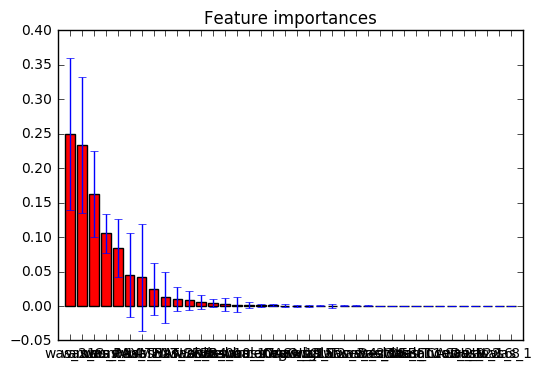

In [31]:
importances = model.feature_importances_
std = np.std([model.feature_importances_ for model in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(df1[features1].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(df1[features1].shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(df1[features1].shape[1]), df1[features1])
plt.xlim([-1, df1[features1].shape[1]])
plt.show()
# Plot the feature importances of the forest
# trying to determine the need of the engineered features

In [32]:
[features1]
# Getting feature names
# .97 of feature importance represented by:
# Features 2, 10, 37, 9, 6, 31, 3, 18, 8

[['was_21',
  'was_C',
  'amount',
  'was_M',
  'was_14',
  'was_PAYMENT',
  'was_5',
  'was_13',
  'was_TRANSFER',
  'was_20',
  'was_7',
  'was_24',
  'was_0',
  'was_10',
  'oldbalanceOrg',
  'was_17',
  'newbalanceOrig',
  'step',
  'was_CASH_OUT',
  'was_19',
  'was_15',
  'was_12',
  'newbalanceDest',
  'was_3',
  'was_4',
  'was_23',
  'was_18',
  'was_DEBIT',
  'was_6',
  'was_11',
  'oldbalanceDest',
  'was_CASH_IN',
  'was_2',
  'was_9',
  'was_22',
  'was_16',
  'was_8',
  'was_1']]

### Process Checkpoint: 1
 I'm rather pleased with my simple Random Forest model utilizing k means feature engineering and a k folds cross validation strategy.  The features driving this model are (in order of importance):
 
Feature ranking:
1. 'newbalanceDest' (0.247011)
2. 'oldbalanceOrg' (0.226982)
3. 'amount' (0.155077)
4. 'step' (0.104939)
5. 'oldbalanceDest' (0.073532)
6. 'was_TRANSFER' (0.064203)
7. 'oldbalanceDest' (0.048071)
8. 'was_CASH_OUT' (0.026618)
9. 'was_CASH_IN' (0.017521)
10. 'was_11' (0.009711)
 
This model did score very high on the public leaderboard putting me at the number one spot with a 0.98416!  I noticed too that of the top models on the private board this model was the only one that had a higher rating on the private board than it had on the public board with a 0.987466.  Even when the model fell from the top spot I still took pride in this fact.

However, the feature ranking is telling me my k means clustering efforts are not really of any value - that I can point to.  Neither is the splitting off of the customer/merchant designation.  Wonder what skipping those steps will mean for model performance. 

 Let's see.... 

In [33]:
df3 = df
df3.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,id,Recipient
0,303,CASH_IN,185164.71,C1499985475,3075480.01,3260644.72,C1771727877,881991.88,696827.18,0,540576,C
1,356,CASH_IN,79083.65,C108745493,5489716.32,5568799.97,C1167754301,153219.51,74135.86,0,120014,C
2,10,TRANSFER,2336832.78,C975415534,147958.78,0.00,C718985478,5069347.06,7307970.46,0,623141,C
3,238,TRANSFER,228517.91,C1968162743,0.00,0.00,C1544755390,18768561.09,18997079.00,0,547737,C
4,133,CASH_IN,180179.73,C467196066,21448.00,201627.73,C1386847873,7160295.13,6980115.40,0,569291,C


In [34]:
df3 = df3.ix[:, [0, 1, 2, 4, 5, 7, 8, 9]]
df3.head()
# dropping unwanted columns

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,303,CASH_IN,185164.71,3075480.01,3260644.72,881991.88,696827.18,0
1,356,CASH_IN,79083.65,5489716.32,5568799.97,153219.51,74135.86,0
2,10,TRANSFER,2336832.78,147958.78,0.00,5069347.06,7307970.46,0
3,238,TRANSFER,228517.91,0.00,0.00,18768561.09,18997079.00,0
4,133,CASH_IN,180179.73,21448.00,201627.73,7160295.13,6980115.40,0


In [35]:
df3.head()
# Confirming transformation

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,303,CASH_IN,185164.71,3075480.01,3260644.72,881991.88,696827.18,0
1,356,CASH_IN,79083.65,5489716.32,5568799.97,153219.51,74135.86,0
2,10,TRANSFER,2336832.78,147958.78,0.00,5069347.06,7307970.46,0
3,238,TRANSFER,228517.91,0.00,0.00,18768561.09,18997079.00,0
4,133,CASH_IN,180179.73,21448.00,201627.73,7160295.13,6980115.40,0


In [36]:
df3 = pd.get_dummies(df3, prefix='was', prefix_sep='_')
df3.head()
# encoding categorical features

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER
0,303,185164.71,3075480.01,3260644.72,881991.88,696827.18,0,1.0,0.0,0.0,0.0,0.0
1,356,79083.65,5489716.32,5568799.97,153219.51,74135.86,0,1.0,0.0,0.0,0.0,0.0
2,10,2336832.78,147958.78,0.00,5069347.06,7307970.46,0,0.0,0.0,0.0,0.0,1.0
3,238,228517.91,0.00,0.00,18768561.09,18997079.00,0,0.0,0.0,0.0,0.0,1.0
4,133,180179.73,21448.00,201627.73,7160295.13,6980115.40,0,1.0,0.0,0.0,0.0,0.0


In [37]:
features3 = list(set(df3.columns) - {'isFraud'})
print(features3)
# setting features to a list

['oldbalanceDest', 'amount', 'was_TRANSFER', 'was_CASH_IN', 'newbalanceDest', 'newbalanceOrig', 'was_PAYMENT', 'was_CASH_OUT', 'was_DEBIT', 'oldbalanceOrg', 'step']


In [38]:
df3.shape
# 509009 row & 12

(509009, 12)

In [39]:
model3 = RandomForestClassifier(n_estimators=125, n_jobs=-1, random_state=0)
model3.fit(df3[features3], df3.isFraud)
# fitting the model3 to the train data set

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=125, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [40]:
kf = StratifiedKFold(n_splits=5)
# setting folds to 5

In [41]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model3, df3[features3],
                         df3.isFraud, scoring='accuracy', cv=kf)
print(scores)
print(scores.mean())
# running kfolds model

[ 0.99964637  0.9996562   0.9996169   0.99959726  0.99971513]
0.99964637181


In [42]:
print("Model R^2 score on entire train data: %s" %
      model3.score(df3[features3], df3.isFraud))
# scoring full train set

Model R^2 score on entire train data: 1.0


In [43]:
dftest3 = pd.read_csv('test.csv')
dftest3.head()
# importing test data set

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,id
0,257,CASH_OUT,208758.36,C1628429873,186770.00,0.00,C703878081,98209.59,306967.94,98777
1,375,PAYMENT,8078.82,C1642149666,40458.00,32379.18,M1726657457,0.00,0.00,397457
2,168,CASH_OUT,60783.19,C346779827,0.00,0.00,C1063782390,747531.29,808314.48,592225
3,590,CASH_IN,267290.88,C713342712,4646500.36,4913791.24,C1390373129,299549.13,32258.25,425029
4,377,CASH_IN,226575.08,C1831624676,7615712.40,7842287.48,C1453112071,1822519.59,1595944.51,118706


In [44]:
dftest3 = dftest3.ix[:, [0, 1, 2, 4, 5, 7, 8]]
dftest3.info()
# dropping unwanted columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127253 entries, 0 to 127252
Data columns (total 7 columns):
step              127253 non-null int64
type              127253 non-null object
amount            127253 non-null float64
oldbalanceOrg     127253 non-null float64
newbalanceOrig    127253 non-null float64
oldbalanceDest    127253 non-null float64
newbalanceDest    127253 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 6.8+ MB


In [45]:
dftest3 = pd.get_dummies(dftest3, prefix='was', prefix_sep='_')
dftest3.head()
# encoding categorical features

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER
0,257,208758.36,186770.00,0.00,98209.59,306967.94,0.0,1.0,0.0,0.0,0.0
1,375,8078.82,40458.00,32379.18,0.00,0.00,0.0,0.0,0.0,1.0,0.0
2,168,60783.19,0.00,0.00,747531.29,808314.48,0.0,1.0,0.0,0.0,0.0
3,590,267290.88,4646500.36,4913791.24,299549.13,32258.25,1.0,0.0,0.0,0.0,0.0
4,377,226575.08,7615712.40,7842287.48,1822519.59,1595944.51,1.0,0.0,0.0,0.0,0.0


In [46]:
preds3 = model3.predict_proba(dftest3[features3])[:, 1]
# making predictions on test data using full feature list

In [47]:
preds3
# making sure predictions are probabilities

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [48]:
len(preds3)
# verifying preditions were on correct dataset

127253

In [49]:
submit = {'Prediction': preds3, 'id': dftest.id}
# making dictionary of predictions and ids

In [50]:
submit = pd.DataFrame(submit)
submit.head()
# creating dataframe

,Prediction,id
0,0.0,98777
1,0.0,397457
2,0.0,592225
3,0.0,425029
4,0.0,118706


In [51]:
submit.to_csv('rt150pluskmeanspluskfolds3.csv')
# exporting dataframe to .csv for submittal

In [52]:
importances3 = model3.feature_importances_
std = np.std([model3.feature_importances_ for model3 in model3.estimators_],
             axis=0)
indices = np.argsort(importances3)[::-1]
print("Feature ranking:")
for f in range(dftest3.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f],
                                   importances3[indices[f]]))
# Print the feature ranking

Feature ranking:
1. feature 4 (0.299738)
2. feature 9 (0.249815)
3. feature 1 (0.169107)
4. feature 10 (0.103635)
5. feature 0 (0.077986)
6. feature 2 (0.036284)
7. feature 5 (0.034385)
8. feature 7 (0.021780)
9. feature 3 (0.006198)
10. feature 6 (0.000953)
11. feature 8 (0.000120)


In [53]:
[features3]
# Getting feature names
# .97 of feature importance represented by:
# Features 2, 10, 37, 9, 6, 31, 3, 18, 8

[['oldbalanceDest',
  'amount',
  'was_TRANSFER',
  'was_CASH_IN',
  'newbalanceDest',
  'newbalanceOrig',
  'was_PAYMENT',
  'was_CASH_OUT',
  'was_DEBIT',
  'oldbalanceOrg',
  'step']]

### Process Checkpoint 2
   The features drving this model are (in order of importance):
Feature ranking:
1. 'newbalanceDest' (0.286333)
2. 'oldbalanceOrg' (0.235791)
3. 'amount' (0.168333)
4. 'step' (0.102982)
5. 'oldbalanceDest' (0.081684)
6. 'was_TRANSFER' (0.052463)
7. 'newbalanceOrig' (0.033896)
8. 'was_CASH_OUT' (0.032355)
9. 'was_CASH_IN' (0.003684)
10. 'was_PAYMENT (0.002448)
11. 'was_DEBIT' (0.000030)
 
We're getting better in model structure but losing performance based on leaderboard score.  My features are less in number paring them back to 11 from 38 but when submitting to the leaderboard my public score was 0.968805 and a private score of 0.985681.  Again, my private score surpasses my public score and I beleive this to be good my my over all scores degraded as did my ranking.  

This tells me that despite the kmeans clustering perhaps not adding showing values when viewing the feature importances, they indeed have some value and shall be added back to my next iteration.  Next interation?  Yes.  Perhaps it is time to employ a feature scaling techniques and to try a switch in models.  Let's double our kmeans too - just for fun.

As we get closer to our production model it is becoming clear the the things to look for when trying to detect fraudulent transactions are the size of the new balance of the destitation accounts, the beginning balances of the origin accounts, the transaction amount and the time of day.  Regardless of the presence of the kmeans clustering, these four features were found at the top of the feature importances which makes sense to me.  Our thieves clearly want to target getting the most reward for the risk associated with their nefarious activities.

Let's further tweak our model and put an end to their criminal activities.

In [54]:
df4 = df
df4.head()
# setting up df4

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,id,Recipient
0,303,CASH_IN,185164.71,C1499985475,3075480.01,3260644.72,C1771727877,881991.88,696827.18,0,540576,C
1,356,CASH_IN,79083.65,C108745493,5489716.32,5568799.97,C1167754301,153219.51,74135.86,0,120014,C
2,10,TRANSFER,2336832.78,C975415534,147958.78,0.00,C718985478,5069347.06,7307970.46,0,623141,C
3,238,TRANSFER,228517.91,C1968162743,0.00,0.00,C1544755390,18768561.09,18997079.00,0,547737,C
4,133,CASH_IN,180179.73,C467196066,21448.00,201627.73,C1386847873,7160295.13,6980115.40,0,569291,C


In [55]:
df4['Recipient'] = df4['nameDest'].str[:1]
df4.head()
# Splitting nameDest to retain letter

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,id,Recipient
0,303,CASH_IN,185164.71,C1499985475,3075480.01,3260644.72,C1771727877,881991.88,696827.18,0,540576,C
1,356,CASH_IN,79083.65,C108745493,5489716.32,5568799.97,C1167754301,153219.51,74135.86,0,120014,C
2,10,TRANSFER,2336832.78,C975415534,147958.78,0.00,C718985478,5069347.06,7307970.46,0,623141,C
3,238,TRANSFER,228517.91,C1968162743,0.00,0.00,C1544755390,18768561.09,18997079.00,0,547737,C
4,133,CASH_IN,180179.73,C467196066,21448.00,201627.73,C1386847873,7160295.13,6980115.40,0,569291,C


In [56]:
df4 = df4.ix[:, [0, 1, 2, 4, 5, 7, 8, 9, 11]]
df4.head()
# dropping unwanted columns

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Recipient
0,303,CASH_IN,185164.71,3075480.01,3260644.72,881991.88,696827.18,0,C
1,356,CASH_IN,79083.65,5489716.32,5568799.97,153219.51,74135.86,0,C
2,10,TRANSFER,2336832.78,147958.78,0.00,5069347.06,7307970.46,0,C
3,238,TRANSFER,228517.91,0.00,0.00,18768561.09,18997079.00,0,C
4,133,CASH_IN,180179.73,21448.00,201627.73,7160295.13,6980115.40,0,C


In [57]:
df4.amount = np.log1p(df4.amount)
df4.oldbalanceOrg = np.log1p(df4.oldbalanceOrg)
df4.newbalanceOrig = np.log1p(df4.newbalanceOrig)
df4.oldbalanceDest = np.log1p(df4.oldbalanceDest)
df4.newbalanceDest = np.log1p(df4.newbalanceDest)
df4.step = np.log1p(df4.step)
# transforming values to normally distributed

In [58]:
df4.head()
# confirming transformation

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Recipient
0,5.717028,CASH_IN,12.129006,14.938972,14.997436,13.689939,13.454294,0,C
1,5.877736,CASH_IN,11.278274,15.518387,15.532690,11.939633,11.213668,0,C
2,2.397895,TRANSFER,14.664307,11.904696,0.000000,15.438723,15.804476,0,C
3,5.476464,TRANSFER,12.339374,0.000000,0.000000,16.747694,16.759796,0,C
4,4.897840,CASH_IN,12.101716,9.973433,12.214183,15.784062,15.758576,0,C


In [59]:
df4 = pd.get_dummies(df4, prefix='was', prefix_sep='_')
df4.head()
# encoding categorical features

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER,was_C,was_M
0,5.717028,12.129006,14.938972,14.997436,13.689939,13.454294,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5.877736,11.278274,15.518387,15.532690,11.939633,11.213668,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.397895,14.664307,11.904696,0.000000,15.438723,15.804476,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,5.476464,12.339374,0.000000,0.000000,16.747694,16.759796,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,4.897840,12.101716,9.973433,12.214183,15.784062,15.758576,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [60]:
features4 = list(set(df4.columns) - {'isFraud'})
print(features4)
# setting features to a list

['oldbalanceDest', 'was_C', 'amount', 'was_M', 'was_TRANSFER', 'was_CASH_IN', 'newbalanceDest', 'newbalanceOrig', 'was_PAYMENT', 'was_CASH_OUT', 'was_DEBIT', 'oldbalanceOrg', 'step']


In [61]:
kmeans = KMeans(n_clusters=50, random_state=0, n_jobs=-1)
kmeans.fit(df4[features4])
# breaking data into 50 clusters based on features

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [62]:
predictedLabels = kmeans.predict(df4[features4])
df4['predictedCluster'] = predictedLabels
df4['predictedCluster'] = df4.predictedCluster.astype('object')
# setting predicted clusters to variable
# adding predicted clusters to df1
# setting new feature dtype

In [63]:
df4.head()
# confirming transformation

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER,was_C,was_M,predictedCluster
0,5.717028,12.129006,14.938972,14.997436,13.689939,13.454294,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6
1,5.877736,11.278274,15.518387,15.532690,11.939633,11.213668,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27
2,2.397895,14.664307,11.904696,0.000000,15.438723,15.804476,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,9
3,5.476464,12.339374,0.000000,0.000000,16.747694,16.759796,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,38
4,4.897840,12.101716,9.973433,12.214183,15.784062,15.758576,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,25


In [64]:
df4 = pd.get_dummies(df4, prefix='was', prefix_sep='_')
df4.head()
# encoding categorical features

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,was_CASH_IN,was_CASH_OUT,was_DEBIT,...,was_40,was_41,was_42,was_43,was_44,was_45,was_46,was_47,was_48,was_49
0,5.717028,12.129006,14.938972,14.997436,13.689939,13.454294,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.877736,11.278274,15.518387,15.532690,11.939633,11.213668,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.397895,14.664307,11.904696,0.000000,15.438723,15.804476,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.476464,12.339374,0.000000,0.000000,16.747694,16.759796,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.897840,12.101716,9.973433,12.214183,15.784062,15.758576,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
features4 = list(set(df4.columns) - {'isFraud'})
print(features4)
# setting features to a list

['was_C', 'was_37', 'was_25', 'was_13', 'was_TRANSFER', 'was_20', 'was_7', 'was_0', 'was_40', 'was_42', 'was_17', 'newbalanceOrig', 'was_45', 'was_CASH_OUT', 'was_48', 'was_12', 'was_32', 'was_39', 'was_29', 'was_4', 'was_34', 'was_11', 'was_31', 'was_43', 'was_30', 'was_2', 'was_22', 'was_49', 'was_8', 'was_38', 'was_1', 'was_21', 'amount', 'was_M', 'was_14', 'was_PAYMENT', 'was_33', 'was_35', 'was_5', 'was_27', 'was_47', 'was_44', 'was_24', 'was_28', 'was_10', 'oldbalanceOrg', 'step', 'was_26', 'was_19', 'was_46', 'was_15', 'newbalanceDest', 'was_3', 'was_23', 'was_18', 'was_DEBIT', 'was_36', 'was_6', 'was_41', 'oldbalanceDest', 'was_CASH_IN', 'was_9', 'was_16']


In [66]:
df4.shape
# 509009 row & 64 columns

(509009, 64)

In [67]:
train, test = tts(df4, test_size=.2, random_state=0)
# splitting df4 into train/test sets

In [68]:
train.info()
# verifiyng train = 80% of df4

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407207 entries, 320262 to 461484
Data columns (total 64 columns):
step              407207 non-null float64
amount            407207 non-null float64
oldbalanceOrg     407207 non-null float64
newbalanceOrig    407207 non-null float64
oldbalanceDest    407207 non-null float64
newbalanceDest    407207 non-null float64
isFraud           407207 non-null int64
was_CASH_IN       407207 non-null float64
was_CASH_OUT      407207 non-null float64
was_DEBIT         407207 non-null float64
was_PAYMENT       407207 non-null float64
was_TRANSFER      407207 non-null float64
was_C             407207 non-null float64
was_M             407207 non-null float64
was_0             407207 non-null float64
was_1             407207 non-null float64
was_2             407207 non-null float64
was_3             407207 non-null float64
was_4             407207 non-null float64
was_5             407207 non-null float64
was_6             407207 non-null float64
was_

In [69]:
ptr = []
p = []
for i in np.logspace(-10, 2, num=15):
    model4 = LinearSVC(C=i, random_state=0)
    model4.fit(train[features4], train.isFraud)
    print(70*"#")
    trainscore = model4.score(train[features4], train.isFraud)
    print("Model accuracy score on training data with hyperparameter of %s: %s"
          % (i, trainscore))
    testscore = model4.score(test[features4], test.isFraud)
    print("Model accuracy score on test data with hyperparameter of %s: %s"
          % (i, testscore))
    print("Number of features in the model: {}"
          .format(np.sum(model4.coef_ != 0)))
    print(70*"#", "\n")
    ptr.append(trainscore)
    p.append(testscore)
    # iterating on regularization hyperparameter
    # l2 penalty is ridge regularization

######################################################################
Model accuracy score on training data with hyperparameter of 1e-10: 0.998691083405
Model accuracy score on test data with hyperparameter of 1e-10: 0.998664073397
Number of features in the model: 63
###################################################################### 

######################################################################
Model accuracy score on training data with hyperparameter of 7.19685673001e-10: 0.998691083405
Model accuracy score on test data with hyperparameter of 7.19685673001e-10: 0.998664073397
Number of features in the model: 63
###################################################################### 

######################################################################
Model accuracy score on training data with hyperparameter of 5.17947467923e-09: 0.998691083405
Model accuracy score on test data with hyperparameter of 5.17947467923e-09: 0.998664073397
Number of features in the model: 63

In [70]:
model4 = LinearSVC(C=1.93069772888, random_state=0)
model4.fit(train[features4], train.isFraud)
# resetting model to current best results

LinearSVC(C=1.93069772888, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [71]:
ptr = []
p = []
for i in np.logspace(-10, 2, num=15):
    model4 = LinearSVC(C=i, random_state=0)
    model4.fit(df4[features4], df4.isFraud)
    print(70*"#")
    fullscore = model4.score(df4[features4], df4.isFraud)
    print("Model accuracy score on training data with hyperparameter of %s: %s"
          % (i, fullscore))
    print("Number of features in the model: {}"
          .format(np.sum(model4.coef_ != 0)))
    print(70*"#", "\n")
    ptr.append(trainscore)
    p.append(testscore)
    # fitting to full training set for comparison
    # iterating on regularization hyperparameter
    # l2 penalty is ridge regularization

######################################################################
Model accuracy score on training data with hyperparameter of 1e-10: 0.998685681393
Number of features in the model: 63
###################################################################### 

######################################################################
Model accuracy score on training data with hyperparameter of 7.19685673001e-10: 0.998685681393
Number of features in the model: 63
###################################################################### 

######################################################################
Model accuracy score on training data with hyperparameter of 5.17947467923e-09: 0.998685681393
Number of features in the model: 63
###################################################################### 

######################################################################
Model accuracy score on training data with hyperparameter of 3.72759372031e-08: 0.998685681393
Number of features in

Very pleased that the c values for both my train/test and full train trials resulted in the same suggested C and that now my model is in it's final state - for now.......

In [72]:
dftest4 = pd.read_csv('test.csv')
dftest4.head()
# importing test data set

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,id
0,257,CASH_OUT,208758.36,C1628429873,186770.00,0.00,C703878081,98209.59,306967.94,98777
1,375,PAYMENT,8078.82,C1642149666,40458.00,32379.18,M1726657457,0.00,0.00,397457
2,168,CASH_OUT,60783.19,C346779827,0.00,0.00,C1063782390,747531.29,808314.48,592225
3,590,CASH_IN,267290.88,C713342712,4646500.36,4913791.24,C1390373129,299549.13,32258.25,425029
4,377,CASH_IN,226575.08,C1831624676,7615712.40,7842287.48,C1453112071,1822519.59,1595944.51,118706


In [73]:
dftest4['Recipient'] = dftest4['nameDest'].str[:1]
dftest4.head()
# Splitting nameDest to retain letter

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,id,Recipient
0,257,CASH_OUT,208758.36,C1628429873,186770.00,0.00,C703878081,98209.59,306967.94,98777,C
1,375,PAYMENT,8078.82,C1642149666,40458.00,32379.18,M1726657457,0.00,0.00,397457,M
2,168,CASH_OUT,60783.19,C346779827,0.00,0.00,C1063782390,747531.29,808314.48,592225,C
3,590,CASH_IN,267290.88,C713342712,4646500.36,4913791.24,C1390373129,299549.13,32258.25,425029,C
4,377,CASH_IN,226575.08,C1831624676,7615712.40,7842287.48,C1453112071,1822519.59,1595944.51,118706,C


In [74]:
dftest4 = dftest4.ix[:, [0, 1, 2, 4, 5, 7, 8, 10]]
dftest4.head()
# dropping unwanted columns

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Recipient
0,257,CASH_OUT,208758.36,186770.00,0.00,98209.59,306967.94,C
1,375,PAYMENT,8078.82,40458.00,32379.18,0.00,0.00,M
2,168,CASH_OUT,60783.19,0.00,0.00,747531.29,808314.48,C
3,590,CASH_IN,267290.88,4646500.36,4913791.24,299549.13,32258.25,C
4,377,CASH_IN,226575.08,7615712.40,7842287.48,1822519.59,1595944.51,C


In [75]:
dftest4.amount = np.log1p(dftest4.amount)
dftest4.oldbalanceOrg = np.log1p(dftest4.oldbalanceOrg)
dftest4.newbalanceOrig = np.log1p(dftest4.newbalanceOrig)
dftest4.oldbalanceDest = np.log1p(dftest4.oldbalanceDest)
dftest4.newbalanceDest = np.log1p(dftest4.newbalanceDest)
dftest4.step = np.log1p(dftest4.step)
# transforming values to normally distributed

In [76]:
dftest4.head()
# confirming transformation

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Recipient
0,5.552960,CASH_OUT,12.248937,12.137639,0.000000,11.494869,12.634502,C
1,5.929589,PAYMENT,8.997125,10.608044,10.385302,0.000000,0.000000,M
2,5.129899,CASH_OUT,11.015085,0.000000,0.000000,13.524533,13.602708,C
3,6.381816,CASH_IN,12.496097,15.351625,15.407557,12.610037,10.381560,C
4,5.934894,CASH_IN,12.330836,15.845724,15.875041,14.415731,14.282977,C


In [77]:
dftest4 = pd.get_dummies(dftest4, prefix='was', prefix_sep='_')
dftest4.head()
# encoding categorical features

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER,was_C,was_M
0,5.552960,12.248937,12.137639,0.000000,11.494869,12.634502,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,5.929589,8.997125,10.608044,10.385302,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,5.129899,11.015085,0.000000,0.000000,13.524533,13.602708,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,6.381816,12.496097,15.351625,15.407557,12.610037,10.381560,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.934894,12.330836,15.845724,15.875041,14.415731,14.282977,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [78]:
features4 = list(set(dftest4.columns) - {'isFraud'})
print(features4)
# setting features to a list

['oldbalanceDest', 'was_C', 'amount', 'was_M', 'was_TRANSFER', 'was_CASH_IN', 'newbalanceDest', 'newbalanceOrig', 'was_PAYMENT', 'was_DEBIT', 'oldbalanceOrg', 'step', 'was_CASH_OUT']


In [79]:
kmeans = KMeans(n_clusters=50, random_state=0, n_jobs=-1)
kmeans.fit(dftest4[features4])
# breaking data into 50 clusters based on features

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [80]:
predictedLabels = kmeans.predict(dftest4[features4])
dftest4['predictedCluster'] = predictedLabels
dftest4['predictedCluster'] = dftest4.predictedCluster.astype('object')
# setting predicted clusters to variable
# adding predicted clusters to df1
# setting new feature dtype

In [81]:
dftest4.head()
# confirming transformation

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,was_TRANSFER,was_C,was_M,predictedCluster
0,5.552960,12.248937,12.137639,0.000000,11.494869,12.634502,0.0,1.0,0.0,0.0,0.0,1.0,0.0,18
1,5.929589,8.997125,10.608044,10.385302,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,27
2,5.129899,11.015085,0.000000,0.000000,13.524533,13.602708,0.0,1.0,0.0,0.0,0.0,1.0,0.0,44
3,6.381816,12.496097,15.351625,15.407557,12.610037,10.381560,1.0,0.0,0.0,0.0,0.0,1.0,0.0,42
4,5.934894,12.330836,15.845724,15.875041,14.415731,14.282977,1.0,0.0,0.0,0.0,0.0,1.0,0.0,36


In [82]:
dftest4 = pd.get_dummies(dftest4, prefix='was', prefix_sep='_')
dftest4.head()
# encoding categorical features

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,...,was_40,was_41,was_42,was_43,was_44,was_45,was_46,was_47,was_48,was_49
0,5.552960,12.248937,12.137639,0.000000,11.494869,12.634502,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.929589,8.997125,10.608044,10.385302,0.000000,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.129899,11.015085,0.000000,0.000000,13.524533,13.602708,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,6.381816,12.496097,15.351625,15.407557,12.610037,10.381560,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.934894,12.330836,15.845724,15.875041,14.415731,14.282977,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
features4 = list(set(df4.columns) - {'isFraud'})
print(features4)
# setting features to a list

['was_C', 'was_37', 'was_25', 'was_13', 'was_TRANSFER', 'was_20', 'was_7', 'was_0', 'was_40', 'was_42', 'was_17', 'newbalanceOrig', 'was_45', 'was_CASH_OUT', 'was_48', 'was_12', 'was_32', 'was_39', 'was_29', 'was_4', 'was_34', 'was_11', 'was_31', 'was_43', 'was_30', 'was_2', 'was_22', 'was_49', 'was_8', 'was_38', 'was_1', 'was_21', 'amount', 'was_M', 'was_14', 'was_PAYMENT', 'was_33', 'was_35', 'was_5', 'was_27', 'was_47', 'was_44', 'was_24', 'was_28', 'was_10', 'oldbalanceOrg', 'step', 'was_26', 'was_19', 'was_46', 'was_15', 'newbalanceDest', 'was_3', 'was_23', 'was_18', 'was_DEBIT', 'was_36', 'was_6', 'was_41', 'oldbalanceDest', 'was_CASH_IN', 'was_9', 'was_16']


In [84]:
dftest4.shape
# 127243 row & 63 columns

(127253, 63)

In [85]:
preds4 = model4.decision_function(dftest4[features4])

In [86]:
preds4
# making sure predictions are probabilities

array([  1.65677225,  -9.71213395, -18.45521579, ...,  -5.85185491,
       -19.78776979, -18.81740243])

In [87]:
len(preds4)
# verifying preditions were on correct dataset

127253

In [88]:
submit = {'Prediction': preds4, 'id': dftest.id}
# making dictionary of predictions and ids

In [89]:
submit = pd.DataFrame(submit)
submit.head()
# creating dataframe

,Prediction,id
0,1.656772,98777
1,-9.712134,397457
2,-18.455216,592225
3,-10.895265,425029
4,-10.366523,118706


In [90]:
submit.to_csv('rt150pluskmeanspluskfolds4.csv')
# exporting dataframe to .csv for submittal

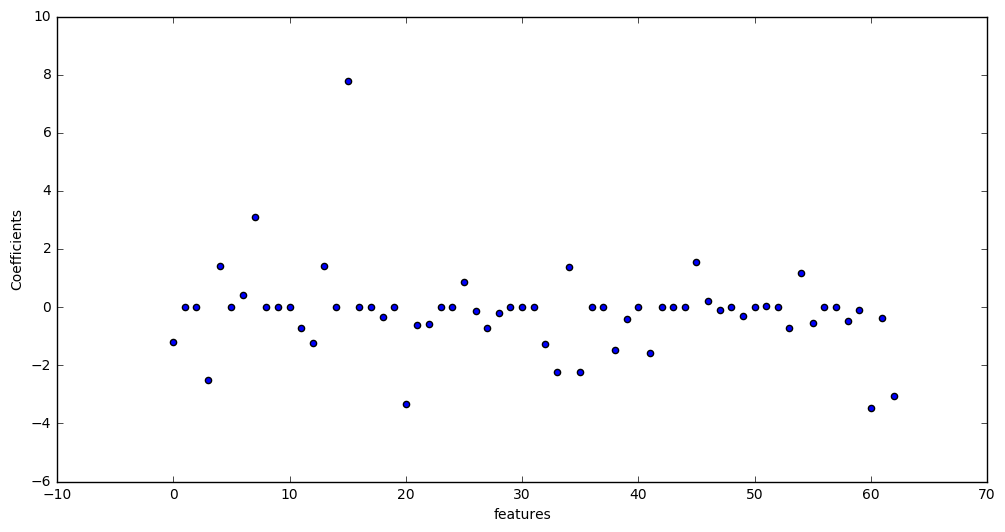

In [91]:
pd.DataFrame({"Coefficients": np.ravel(model4.coef_), "features":
              list(range(len((features4))))}).plot(kind='scatter',
                                                   y='Coefficients',
                                                   x='features',
                                                   figsize=(12, 6))
# vizualizing coefficient importance

In [92]:
model4.coef_
# Print the Coefficient weights
# Wha?

array([[ -1.21542073e+00,   1.95156391e-17,   0.00000000e+00,
         -2.49405659e+00,   1.41867217e+00,   8.23993651e-17,
          4.15871781e-01,   3.08847557e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -7.22731775e-01,
         -1.22104876e+00,   1.40017770e+00,   2.16840434e-19,
          7.78275838e+00,   4.33680869e-19,  -6.93889390e-18,
         -3.54900341e-01,   0.00000000e+00,  -3.33201441e+00,
         -6.01387118e-01,  -5.65342652e-01,   0.00000000e+00,
         -1.52465931e-19,   8.70705981e-01,  -1.40649428e-01,
         -7.33289230e-01,  -1.93022129e-01,   0.00000000e+00,
         -8.67361738e-19,  -1.95156391e-18,  -1.26849109e+00,
         -2.22851665e+00,   1.38150926e+00,  -2.22851665e+00,
         -2.16840434e-19,   0.00000000e+00,  -1.46197785e+00,
         -4.11108709e-01,   0.00000000e+00,  -1.59487006e+00,
          1.08420217e-19,   0.00000000e+00,   0.00000000e+00,
          1.54031463e+00,   1.98796202e-01,  -8.85265408e-02,
        

In [93]:
[features4]
# Getting feature names

[['was_C',
  'was_37',
  'was_25',
  'was_13',
  'was_TRANSFER',
  'was_20',
  'was_7',
  'was_0',
  'was_40',
  'was_42',
  'was_17',
  'newbalanceOrig',
  'was_45',
  'was_CASH_OUT',
  'was_48',
  'was_12',
  'was_32',
  'was_39',
  'was_29',
  'was_4',
  'was_34',
  'was_11',
  'was_31',
  'was_43',
  'was_30',
  'was_2',
  'was_22',
  'was_49',
  'was_8',
  'was_38',
  'was_1',
  'was_21',
  'amount',
  'was_M',
  'was_14',
  'was_PAYMENT',
  'was_33',
  'was_35',
  'was_5',
  'was_27',
  'was_47',
  'was_44',
  'was_24',
  'was_28',
  'was_10',
  'oldbalanceOrg',
  'step',
  'was_26',
  'was_19',
  'was_46',
  'was_15',
  'newbalanceDest',
  'was_3',
  'was_23',
  'was_18',
  'was_DEBIT',
  'was_36',
  'was_6',
  'was_41',
  'oldbalanceDest',
  'was_CASH_IN',
  'was_9',
  'was_16']]

### Process Checkpoint 3

So this model could be titled "A Tale of Two Cities."  On the one hand my public leaderboard score has improved to that of a 0.992386 - leaving only the slightest of margins for conitnued improvement and my best result yet. My private leaderboard rating however was a 0.984878 which is outperformed by both of the Random Forrest models.  Interesting.  Additionally on the negative side would be a general lack of understanding of the SVM model coefficients.  I can visualize them for you but i cannot - as of yet - explain them to an extent that pleases me.  I do take comfort in the fact that this seems to be a common trait with us aspiring data scientists.  This provides me a place to continue my learning and for now I shall move forward.  

So, in the spirit of moving forward I need to figure out why my model scores less successfully on the private leaderboard which uses the AUC as it's success parameter.  I'd like to ignore it but it is a more important measure and worthy of better understanding.

In [94]:
confusion_matrix(df4.isFraud, model4.predict(df4[features4]))
# Recall for not Fraud = 507771/508340 = 99.9%
# Recall for is Fraud = 578/669 = 86.4%
# Precision for not Fraud = 507771/507862 = 99.9%
# Precision for is Fraud = 578/1147 = 50.3%

array([[507771,    569],
       [    91,    578]])

In [95]:
print(classification_report(df4.isFraud, model4.predict(df4[features4])))
# Whoa - not a good precision
# This could explain the poor private leaderboard score

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    508340
          1       0.50      0.86      0.64       669

avg / total       1.00      1.00      1.00    509009



In [96]:
model.fit(df1[features1], df1.isFraud)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=125, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [97]:
confusion_matrix(df1.isFraud, model.predict(df1[features1]))
# Recall for not Fraud = 508340/508340 = 100%
# Recall for is Fraud = 669/669 = 100%
# Precision for not Fraud = 508340/508340 = 100%
# Precision for is Fraud = 669/669 = 100%

array([[508340,      0],
       [     0,    669]])

In [98]:
print(classification_report(df1.isFraud, model.predict(df1[features1])))
# Wow - what a great result
# This could explain the excellent private leaderboard score

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    508340
          1       1.00      1.00      1.00       669

avg / total       1.00      1.00      1.00    509009



### Process Checkpoint 4
So - my issue with not performing well on the private leaderboard resides in the poor performance in my model prediticng too many false positives.  There are far too many and the model needs to be further groomed to address it but it is erring on the correct side of the equation.  This means we as a financial institution would perhaps make more coutesy calls verifying the appropriateness of the transactions prior to them being executed.  Some people will balk at the intrusion but my preference it to err on the side of conservatism until further model improvements can be gained.

In order to compare the private leaderboard results for my final model (model 4) and that of my best model showing (model) I've calculated the confusion matrix for my model.  There is not doubt in my mind now why the private leaderboard performance is so different are this exercise.  

Though not perfect, this model pleases me to the point it could be productionalized for now while further enhancements are gained.  Some of the methods I would use to further drive up the precision of my model4 would include: binning of my numerical features, generating polynomial features and reducing my data dimensions using PCA.  Alas, the boss is here and wants to deploy sometime - asap.

Now we need to build a pipeline......

Starting with a preprocessing function to manipulate raw data into proper format to be trained/tested/scored on the final model

In [99]:
def preprocess_train():
    """
    preprocess()

    Imports pandas as .pd,
    asks for file path and file name,
    1mports .csv file,
    and creates pandas data frame.
    Splits 'nameDest' to retain letter
    Drops unneeded columns
    Gets dummies
    Makes Feature list
    Organizes into 50 kmenas clusters
    Gets dummies
    Makes Feature list

    Parameters
    ----------
    file path:
        local address of file
    file name:
        name of file with extension

    Returns
    -------
    out: data frame
        A Pandas data frame as df

    Examples
    --------
    >>> preprocess()
        What is your file path? C:\\Users\\DN\\hwkkix\\
        data820\\assignments\\assignment-03\\data\\
        What is your file name with extension? 1.csv
    >>> Thanks for helping store your file path and
        name! Enjoy your new dataframe
    """
    import pandas as pd
    path = input('What is your file path? ')
    file = input('What is your file name with extension? ')
    print('Thanks for helping store your file path and name!
          'Enjoy your new dataframe ')
    df = pd.read_csv(path+file)
    df['Recipient'] = df['nameDest'].str[:1]
    df = df.ix[:, [0, 1, 2, 4, 5, 7, 8, 9, 11]]
    df.amount = np.log1p(df.amount)
    df.oldbalanceOrg = np.log1p(df4.oldbalanceOrg)
    df.newbalanceOrig = np.log1p(df.newbalanceOrig)
    df.oldbalanceDest = np.log1p(df.oldbalanceDest)
    df.newbalanceDest = np.log1p(df.newbalanceDest)
    df.step = np.log1p(df.step)
    df = pd.get_dummies(df, prefix='was', prefix_sep='_')
    features = list(set(df.columns) - {'isFraud'})
    kmeans = KMeans(n_clusters=50, random_state=0, n_jobs=-1)
    kmeans.fit(df[features])
    predictedLabels = kmeans.predict(df[features])
    df['predictedCluster'] = predictedLabels
    df['predictedCluster'] = df.predictedCluster.astype('object')
    df = pd.get_dummies(df, prefix='was', prefix_sep='_')
    features = list(set(df.columns) - {'isFraud'})
    return df
# Establish preprocess training script

In [100]:
df = preprocess_train()
df.head()
# running the preprocess function to prep raw data files

What is your file path? C:\Users\DN\hwkkix\detectingfraud\project-submissions\
What is your file name with extension? train.csv
Thanks for helping store your file path and name! Enjoy your new dataframe 


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,was_CASH_IN,was_CASH_OUT,was_DEBIT,...,was_40,was_41,was_42,was_43,was_44,was_45,was_46,was_47,was_48,was_49
0,5.717028,12.129006,2.768767,14.997436,13.689939,13.454294,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.877736,11.278274,2.804474,15.532690,11.939633,11.213668,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.397895,14.664307,2.557591,0.000000,15.438723,15.804476,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.476464,12.339374,0.000000,0.000000,16.747694,16.759796,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4.897840,12.101716,2.395477,12.214183,15.784062,15.758576,0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
train, test = tts(df, test_size=.2, random_state=0)
# splitting data prior to pipeline

In [102]:
pipe = make_pipeline(LinearSVC(C=1.93069772888, random_state=0))
pipe.fit(train[features], train.isFraud)
# establishing pipeline that incorporates PCA and Linear SVM model

Pipeline(steps=[('linearsvc', LinearSVC(C=1.93069772888, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))])

In [103]:
trainscore = pipe.score(train[features], train.isFraud)
print(70*"#")
print("Pipeline model accuracy score on training data set: %s" % (trainscore))
print(70*"#")
# Scoring the pipe on train

######################################################################
Pipeline model accuracy score on training data set: 0.999236260673
######################################################################


In [104]:
testscore = pipe.score(test[features], test.isFraud)
print(70*"#")
print("Pipeline model accuracy score on testing data set: %s" % (testscore))
print(70*"#")
# Scoring the pipe on test

######################################################################
Pipeline model accuracy score on testing data set: 0.999204337832
######################################################################


In [105]:
fullscore = pipe.score(df[features], df.isFraud)
print(70*"#")
print("Pipeline model accuracy score on the full data set: %s" % (fullscore))
print(70*"#")
# Scoring the pipe on full data set

######################################################################
Pipeline model accuracy score on the full data set: 0.999229876093
######################################################################


In [106]:
confusion_matrix(df.isFraud, pipe.predict(df[features]))
# Recall for not Fraud = 508325/508350 = 99.9%
# Recall for is Fraud = 292/669 = 44%
# Precision for not Fraud = 508325/508702 = 99.9%
# Precision for is Fraud = 292/307 = 95%

array([[508325,     15],
       [   377,    292]])

In [107]:
print(classification_report(df.isFraud, pipe.predict(df[features])))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    508340
          1       0.95      0.44      0.60       669

avg / total       1.00      1.00      1.00    509009



In [108]:
def preprocess_test():
    """
    preprocess()

    Imports pandas as .pd,
    asks for file path and file name
    1mports .csv file, and creates pandas data frame.
    Splits 'nameDest' to retain letter
    Drops unneeded columns
    Gets dummies
    Makes Feature list
    Organizes into 50 kmenas clusters
    Gets dummies
    Makes Feature list

    Parameters
    ----------
    file path:
        local address of file
    file name:
        name of file with extension

    Returns
    -------
    out: data frame
        A Pandas data frame as df

    Examples
    --------
    >>> preprocess()
        What is your file path? C:\\Users\\DN\\hwkkix\\
        data820\\assignments\\assignment-03\\data\\
        What is your file name with extension? 1.csv
    >>> Thanks for helping store your file path and
        name! Enjoy your new dataframe
    """
    import pandas as pd
    path = input('What is your file path? ')
    file = input('What is your file name with extension? ')
    print('Thanks for helping store your file path and name!
          'Enjoy your new dataframe ')
    df = pd.read_csv(path+file)
    df['Recipient'] = df['nameDest'].str[:1]
    df = df.ix[:, [0, 1, 2, 4, 5, 7, 8, 10]]
    df.amount = np.log1p(df.amount)
    df.oldbalanceOrg = np.log1p(df4.oldbalanceOrg)
    df.newbalanceOrig = np.log1p(df.newbalanceOrig)
    df.oldbalanceDest = np.log1p(df.oldbalanceDest)
    df.newbalanceDest = np.log1p(df.newbalanceDest)
    df.step = np.log1p(df.step)
    df = pd.get_dummies(df, prefix='was', prefix_sep='_')
    features = list(set(df.columns) - {'isFraud'})
    kmeans = KMeans(n_clusters=50, random_state=0, n_jobs=-1)
    kmeans.fit(df[features])
    predictedLabels = kmeans.predict(df[features])
    df['predictedCluster'] = predictedLabels
    df['predictedCluster'] = df.predictedCluster.astype('object')
    df = pd.get_dummies(df, prefix='was', prefix_sep='_')
    features = list(set(df.columns) - {'isFraud'})
    return df
# Establish preprocess testing script

In [109]:
df = preprocess_test()
df.head()
# running the preprocess function to prep raw data files

What is your file path? C:\Users\DN\hwkkix\detectingfraud\project-submissions\
What is your file name with extension? test.csv
Thanks for helping store your file path and name! Enjoy your new dataframe 


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,was_CASH_IN,was_CASH_OUT,was_DEBIT,was_PAYMENT,...,was_40,was_41,was_42,was_43,was_44,was_45,was_46,was_47,was_48,was_49
0,5.552960,12.248937,2.768767,0.000000,11.494869,12.634502,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.929589,8.997125,2.804474,10.385302,0.000000,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.129899,11.015085,2.557591,0.000000,13.524533,13.602708,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6.381816,12.496097,0.000000,15.407557,12.610037,10.381560,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.934894,12.330836,2.395477,15.875041,14.415731,14.282977,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
preds = pipe.decision_function(df[features])

In [111]:
preds
# making sure predictions are probabilities

array([ -0.19706743,  -0.79550982,  -0.95808095, ...,  -1.63712136,
        -1.61279643, -10.03964371])

In [112]:
len(preds)
# verifying preditions were on correct dataset

127253

In [113]:
submit = {'Prediction': preds, 'id': dftest.id}
# making dictionary of predictions and ids

In [114]:
submit = pd.DataFrame(submit)
submit.head()
# creating dataframe

,Prediction,id
0,-0.197067,98777
1,-0.795510,397457
2,-0.958081,592225
3,-11.905882,425029
4,-4.076398,118706


In [115]:
submit.to_csv('rt150pluskmeanspluskfolds6.csv')
# exporting dataframe to .csv for submittal

### Process Checkpoint 5

Building my pipeline turned into a pipe bomb!  Submitting my version 6 .csv resulted in a 0.684476 public leaderboard score and a 0.659461 private leaderboard score.  These two scores would lead me back to the drawing board.  

# Help!!

In [116]:
@interact
def plotroc(C=(0, 100, 1)):
    model5 = LinearSVC(C=C, random_state=0).fit(train[features5],
                                                train.isFraud)
    fpr, recall, thresholds = roc_curve(
        test.isFraud, model5.decision_function(test[features5]))
    plt.figure(figsize=(12, 8))
    plt.plot(fpr, recall)
    print('Accuracy score is: %s'
          % accuracy_score(test.isFraud, model5.predict(test[features5])))
# I do not think i did this correctly
# wanted to keep it in case you can help on why

NameError: name 'features5' is not defined

My pipeline is messed up too and I could use any advice here that you think may help.